StateGraph를 생성하는 것으로 시작하십시오. StateGraph 객체는 챗봇의 구조를 "상태 기계(State Machine)"로 정의합니다.

nodes를 추가하여 챗봇이 호출할 수 있는 llm과 함수들을 나타내고, edges를 추가하여 봇이 이러한 함수들 간에 어떻게 전환해야 하는지를 지정합니다.

In [1]:
# API 키를 환경변수로 관리하기 위한 설정 파일
from dotenv import load_dotenv

# API 키 정보 로드
load_dotenv()

True

In [2]:
# LangSmith 추적을 설정합니다. https://smith.langchain.com
# !pip install -qU langchain-teddynote
from langchain_teddynote import logging

# 프로젝트 이름을 입력합니다.
logging.langsmith("CH17-LangGraph")


LangSmith 추적을 시작합니다.
[프로젝트명]
CH17-LangGraph


Step-by-Step 개념 이해하기!

STEP 1. 상태(State) 정의

In [3]:
from typing import Annotated, TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # 메시지 정의(list type 이며 add_messages 함수를 사용하여 메시지를 추가)
    messages: Annotated[list, add_messages]


STEP 2. 노드(Node) 정의
- 다음으로 "chatbot" 노드를 추가합니다.
- 노드는 작업의 단위를 나타내며, 일반적으로 정규 Python 함수입니다.

In [11]:
from langchain_openai import ChatOpenAI
from langchain_community.chat_models import ChatOllama

# Ollama 모델을 불러옵니다.
llm = ChatOllama(model="gemma3:1b")

# LLM 정의
# llm = ChatOpenAI(
#     api_key="ollama",
#     model="llama3.2:1b",
#     base_url="http://localhost:11434/v1",
# )


# 챗봇 함수 정의
def chatbot(state: State):
    # 메시지 호출 및 반환
    return {"messages": [llm.invoke(state["messages"])]}


/var/folders/5d/4yvbq7s16359fdr947szsx5h0000gn/T/ipykernel_29355/1255631509.py:5: LangChainDeprecationWarning: The class `ChatOllama` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the :class:`~langchain-ollama package and should be used instead. To use it run `pip install -U :class:`~langchain-ollama` and import as `from :class:`~langchain_ollama import ChatOllama``.
  llm = ChatOllama(model="gemma3:1b")


STEP 3. 그래프(Graph) 정의, 노드 추가

In [12]:
# 그래프 생성
graph_builder = StateGraph(State)

# 노드 이름, 함수 혹은 callable 객체를 인자로 받아 노드를 추가
graph_builder.add_node("chatbot", chatbot)


STEP 4. 그래프 엣지(Edge) 추가
- 다음으로, START 지점을 추가하세요. START는 그래프가 실행될 때마다 작업을 시작할 위치 입니다.

In [13]:
# 시작 노드에서 챗봇 노드로의 엣지 추가
graph_builder.add_edge(START, "chatbot")

마찬가지로, END 지점을 설정하십시오. 이는 그래프 흐름의 종료(끝지점) 를 나타냅니다.

In [14]:
# 그래프에 엣지 추가
graph_builder.add_edge("chatbot", END)

STEP 5. 그래프 컴파일(compile)
- 마지막으로, 그래프를 실행할 수 있어야 합니다. 이를 위해 그래프 빌더에서 "compile()"을 호출합니다. 이렇게 하면 상태에서 호출할 수 있는 "CompiledGraph"가 생성됩니다.

In [15]:
# 그래프 컴파일
graph = graph_builder.compile()

STEP 6. 그래프 시각화

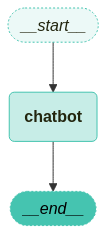

In [16]:
from langchain_teddynote.graphs import visualize_graph

# 그래프 시각화
visualize_graph(graph)


STEP 7. 그래프 실행

In [17]:
question = "서울의 유명한 맛집 TOP 10 추천해줘"

# 그래프 이벤트 스트리밍
for event in graph.stream({"messages": [("user", question)]}):
    # 이벤트 값 출력
    for value in event.values():
        print("Assistant:", value["messages"][-1].content)


Assistant: 서울의 유명 맛집 TOP 10을 추천해 드릴게요! 맛집은 개인 취향에 따라 다르니, 참고해서 즐겨보세요.

**1. 뱅가이드 (뱅가이드 블로그)**

*   **특징:** 서울의 숨겨진 맛집을 찾아주는 뱅가이드의 서울 맛집 추천은 서울의 다양한 음식과 분위기를 경험할 수 있는 최고의 방법입니다.
*   **추천 메뉴:** 떡갈비, 닭갈비, 흑임자 떡볶이 등
*   **링크:** [https://blog.bangvid.kr/best-hidden-restaurants-in-seoul/](https://blog.bangvid.kr/best-hidden-restaurants-in-seoul/)

**2. 쌈지길**

*   **특징:** 쌈 채소와 쌈밥으로 유명한 쌈지길은 낭만적인 분위기 속에서 즐기는 음식 맛집입니다.
*   **추천 메뉴:** 쌈밥, 쌈무, 쌈장 등
*   **링크:** [https://www.sambi.co.kr/](https://www.sambi.co.kr/)

**3. 르완다**

*   **특징:** 르완다는 쌀국수와 곁들임 요리가 유명한 곳입니다. 쌀국수의 풍미를 제대로 느낄 수 있는 곳입니다.
*   **추천 메뉴:** 쌀국수, 꼬치구이, 샐러드 등
*   **링크:** [https://www.lwanza.com/](https://www.lwanza.com/)

**4. 갓 mark**

*   **특징:** 갓 mark는 얇게 썬 고기를 튀겨서 곁들인 튀김 요리 전문점입니다.
*   **추천 메뉴:** 튀김 들bait, 튀김 족발 등
*   **링크:** [https://www.godmark.com/](https://www.godmark.com/)

**5. 앤트맨**

*   **특징:** 앤트맨은 닭갈비와 볶음밥을 맛볼 수 있는 곳입니다. 닭갈비의 매콤함과 볶음밥의 부드러움이 어우러져 있습니다.
*   **추천 메뉴:** 닭갈비, 볶음밥, 닭갈비 볶음 등
*   **링크:** [https://www.andman.